<a href="https://colab.research.google.com/github/DivergentNeuro/EQUAL/blob/main/EQUAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Inputs - Select Device (front end)
You will need to manually run this code to view a list of devices. Once the device is selected, you will need to run the next section of code to present analysis parameters.

In [1]:
#@title
################################################################################
## Written by Chad C. Williams, 2021-2022                                     ##
## Written for Divergence Neuro Technologies Inc.                             ##
## www.divergenceneuro.com                                                    ##
################################################################################

#Install Modules
!pip install mne;

#Import Modules
import os
import ipywidgets as wd
from google.colab import drive
from IPython.display import clear_output
import mne
import math
import copy
import numpy as np
from scipy import fftpack
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib

#Mount Google Drive
drive.mount('/gdrive',force_remount=True)

#Change directory to data
#%cd /gdrive/Shareddrives/Engineering/headset-evaluation/ #<-Divergence file path
%cd /gdrive/MyDrive/headset-evaluation/

#Clear google drive output
clear_output()

#Device selection
print('\033[1m' + 'Select Device:' + '\033[0m') #Display device selection prompt
Device = wd.Dropdown(options=['Artificial', 'BrainVision', 'Crown', 'Neuphony', 'NexStem', 'Zeto'], value = 'Artificial', description = 'Device', disabled = False) #An interactive widget to select the EEG device of interest
display(Device) #Display the widget for use

Select Device:


Dropdown(description='Device', options=('Artificial', 'BrainVision', 'Crown', 'Neuphony', 'NexStem', 'Zeto'), …

# User Inputs - Select Parameters (front end)
Once you have selected your device, you will need to run this code to view analysis parameters. Once these parameters are selected, you will need to run the next section of code that will process and visualize all of the data.


In [2]:
#@title
## User inputs

#### Data Selection ####
print('\033[1m' + '\nSelect File:' + '\033[0m') #Display select file prompt
if Device.value == 'NexStem': #NexStem specific paramaters
  selected_file = wd.Dropdown(options=os.listdir('NexStem-data'), value=os.listdir('NexStem-data')[0], description='File', disabled=False) #Widget that displays all accessible files specific to the device
  display(selected_file) #Display the widget for use
  current_electrodes = mne.channels.read_custom_montage('Montages/nexstem.txt').ch_names #Determine device specific electrode array using a montage
  current_electrodes.insert(0,'Average') #Add an additional 'electrode' that will be used as an option in re-referencing
elif Device.value == 'Zeto': #Zeto specific paramaters
  selected_file = wd.Dropdown(options=os.listdir('Zeto'), value=os.listdir('Zeto')[0], description='File', disabled=False) #Widget that displays all accessible files specific to the device
  display(selected_file) #Display the widget for use
  current_electrodes = mne.channels.read_custom_montage('Montages/zeto.txt').ch_names #Determine device specific electrode array using a montage
  current_electrodes.insert(0,'Average') #Add an additional 'electrode' that will be used as an option in re-referencing
elif Device.value == 'Crown': #Crown specific paramaters
  selected_file = wd.Dropdown(options=os.listdir('crown-data'), value=os.listdir('crown-data')[0], description='File', disabled=False) #Widget that displays all accessible files specific to the device
  display(selected_file) #Display the widget for use
  current_electrodes = mne.channels.read_custom_montage('Montages/crown.txt').ch_names #Determine device specific electrode array using a montage
  current_electrodes.insert(0,'Average') #Add an additional 'electrode' that will be used as an option in re-referencing
elif Device.value == 'BrainVision': #BrainVision specific paramaters
  selected_file = wd.Dropdown(options=os.listdir('BrainVision'), value=os.listdir('BrainVision')[0], description='File', disabled=False) #Widget that displays all accessible files specific to the device
  display(selected_file) #Display the widget for use
  current_electrodes = mne.channels.read_custom_montage('Montages/brainvision.txt').ch_names #Determine device specific electrode array using a montage
  current_electrodes.insert(0,'Average') #Add an additional 'electrode' that will be used as an option in re-referencing
elif Device.value == 'Neuphony': #Neuphony specific paramaters
  selected_file = wd.Dropdown(options=os.listdir('Neuphony'), value=os.listdir('Neuphony')[0], description='File', disabled=False) #Widget that displays all accessible files specific to the device
  display(selected_file) #Display the widget for use
  current_electrodes = mne.channels.read_custom_montage('Montages/neuphony.txt').ch_names #Determine device specific electrode array using a montage
  current_electrodes.insert(0,'Average') #Add an additional 'electrode' that will be used as an option in re-referencing
else: #Data simluation
  selected_file = wd.Dropdown(options=['Simulate Data'], value='Simulate Data', description='File', disabled=False) #Widget that displays all accessible files specific to the simulation
  display(selected_file) #Display the widget for use
  current_electrodes = mne.channels.read_custom_montage('Montages/nexstem.txt').ch_names #Determine device specific electrode array using a montage
  current_electrodes.insert(0,'Average') #Add an additional 'electrode' that will be used as an option in re-referencing

#### PreProcessing UI ####

#### Re-Referencing ####
#This UI function determines whether re-referencing will take place down the line by allowing a user to toggle the step but also to select the electrode to re-reference to
def use_rereference(ReReference): #Define function for re-referencing parameters
  global RR #Variable to determine if pre-processing step will be used
  global select_rereference #Parameters of pre-processing step if it will be used
  select_rereference = wd.Dropdown(options=current_electrodes, value='Average', description='      ', disabled=False) #Dropdown listing 'Average' and every electrode so that user can select reference electrodes
  if ReReference: #Display dropdown
    select_rereference.layout.display = 'visible' #Ensure the dropdown will be visible
    display(select_rereference) #Display the widget for use
    RR = True #Determine that pre-processing step will be run
  else: #Do not display dropdown
    select_rereference.layout.display = 'none' #Ensure the dropdown will not be visible
    display(select_rereference) #Display the widget but will not be visible
    RR = False #Determine that pre-processing step will not be run

#### Edit Channels ####
#This UI function allows the user to view all possible electrodes as a toggle and any that is toggled on will be removed from analyses (and interpolated) down the line
#This does not function for devices with more than 70 electrodes, as these data are rare, yet can be easily adapted to encompass more electrodes if needed
def use_editchans(EditChannels): #Define function for edit channels parameters
  global EC #Variable to determine if pre-processing step will be used
  global available_electrodes #Parameters of pre-processing step if it will be used
  available_electrodes = [wd.Checkbox(description=electrode,set_visible=True) for electrode in current_electrodes[1:]] #A for loop that creates a variable of electrode toggles (excluding the 'Average' electrode), which can be selected for removal
  #The following is to organize the display of electrodes to be across multiple columns rather than a long list
  if len(available_electrodes)>9: #When there are 10+ electrodes
    first_box = wd.VBox(available_electrodes[0:10]) #Select the first ten as the first column
  else: #When there are less than 10 electrodes
    first_box = wd.VBox(available_electrodes[0:]) #Select all available electrodes as the first column

  if len(available_electrodes) > 10: #If there are more than 10 electrodes, we need a second box
    if len(available_electrodes) > 19: #when there are 20+ electrodes
      second_box = wd.VBox(available_electrodes[10:20]) #Select the next ten as the second column
    else: #When there are less than 20 electrodes
      second_box = wd.VBox(available_electrodes[10:]) #Select the remaining electrodes as the second column

  if len(available_electrodes) > 20: #If there are more than 20 electrodes, we need a third box
    if len(available_electrodes) > 29: #When there are 30+ electrodes
      third_box = wd.VBox(available_electrodes[20:30]) #Select the next ten as the third column
    else: #When there are less than 30 electrodes 
      third_box = wd.VBox(available_electrodes[20:]) #Select the remaining electrodes as the third column

  if len(available_electrodes) > 30: #If there are more than 30 electrodes, we need a fourth box
    if len(available_electrodes) > 39: #When there are 40+ electrodes
      fourth_box = wd.VBox(available_electrodes[30:40]) #Select the next ten as the fourth column
    else: #When there are less than 40 electrodes 
      fourth_box = wd.VBox(available_electrodes[30:]) #Select the remaining electrodes as the third column

  if len(available_electrodes) > 40: #If there are more than 40 electrodes, we need a fifth box
    if len(available_electrodes) > 49: #When there are 50+ electrodes
      fifth_box = wd.VBox(available_electrodes[40:50]) #Select the next ten as the fifth column
    else: #When there are less than 50 electrodes 
      fifth_box = wd.VBox(available_electrodes[40:]) #Select the remaining electrodes as the third column

  if len(available_electrodes) > 50: #If there are more than 50 electrodes, we need a sixth box
    if len(available_electrodes) > 59: #When there are 60+ electrodes
      sixth_box = wd.VBox(available_electrodes[50:60]) #Select the next ten as the sixth column
    else: #When there are less than 60 electrodes 
      sixth_box = wd.VBox(available_electrodes[50:]) #Select the remaining electrodes as the third column

  if len(available_electrodes) > 60: #If there are more than 60 electrodes, we need a seventh box
    if len(available_electrodes) > 69: #When there are 70+ electrodes
      seventh_box = wd.VBox(available_electrodes[60:70]) #Select the next ten as the seventh column
    else: #When there are less than 70 electrodes 
      seventh_box = wd.VBox(available_electrodes[60:])#Select the remaining electrodes as the third column

  #Combine columns into a single variable 
  number_of_boxes = math.ceil(len(available_electrodes)/10) #First determine how many columns of ten electrodes will be needed
  if number_of_boxes == 1: #If there is only one column needed
    editchan_boxes = first_box #Assign relevant columns to variable
  elif number_of_boxes == 2: #If there are two columns needed
    editchan_boxes = wd.HBox([first_box, second_box]) #Assign relevant columns to variable
  elif number_of_boxes == 3: #If there are three columns needed
    editchan_boxes = wd.HBox([first_box, second_box, third_box]) #Assign relevant columns to variable
  elif number_of_boxes == 4: #If there are four columns needed
    editchan_boxes = wd.HBox([first_box, second_box, third_box, fourth_box]) #Assign relevant columns to variable
  elif number_of_boxes == 5: #If there are five columns needed
    editchan_boxes = wd.HBox([first_box, second_box, third_box, fourth_box, fifth_box]) #Assign relevant columns to variable
  elif number_of_boxes == 6: #If there are six columns needed
    editchan_boxes = wd.HBox([first_box, second_box, third_box, fourth_box, fifth_box, sixth_box]) #Assign relevant columns to variable
  elif number_of_boxes == 7: #If there are seven columns needed
    editchan_boxes = wd.HBox([first_box, second_box, third_box, fourth_box, fifth_box, sixth_box, seventh_box]) #Assign relevant columns to variable
  else: #A catch input
    print('You did not select data or else we cannot account for so many electrodes!') #If for some reason the electrode list is unavailable, send error message. This is theoretically impossible and will also occur if there are more than 70 electrodes
  
  #Determine the visibility of all the columns
  if EditChannels: #Display checkboxes
    editchan_boxes.layout.display = 'visible' #Ensure the checkboxes will be visible
    EC = True #Determine that pre-processing step will be run
  else: #Do not display checkboxes
    editchan_boxes.layout.display = 'none' #Ensure the checkboxes will not be visible
    EC = False #Determine that pre-processing step will not be run
  display(editchan_boxes) #Display the widget for use
  
#### Filters ####
#Here, we will provide users with two sliding bars for high and low pass filters, and a drop down for a notch filer. 
def use_highpass(HighPass): #Define function for high pass parameters
  global HP #Variable to determine if pre-processing step will be used
  global select_highpass #Parameters of pre-processing step if it will be used
  select_highpass = wd.FloatSlider(value=0.1,min=0,max=1,step=0.1, description='      ', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.1f') #Slider so that user can select high pass value
  if HighPass: #Display slider
    select_highpass.layout.display = 'visible' #Ensure the slider will be visible
    display(select_highpass) #Display the widget for use
    HP = True #Determine that pre-processing step will be run
  else: #Do not display slider
    select_highpass.layout.display = 'none'
    display(select_highpass) #Display the widget for use
    HP = False #Determine that pre-processing step will not be run

def use_lowpass(LowPass): #Define function
  global LP #Variable to determine if pre-processing step will be used
  global select_lowpass #Parameters of pre-processing step if it will be used
  select_lowpass = wd.FloatSlider(value=30,min=1,max=100,step=1, description='      ', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.1f') #Slider so that user can select low pass value
  if LowPass: #Display slider
    select_lowpass.layout.display = 'visible' #Ensure the slider will be visible
    display(select_lowpass) #Display the widget for use
    LP = True #Determine that pre-processing step will be run
  else: #Do not display slider
    select_lowpass.layout.display = 'none'
    display(select_lowpass) #Display the widget for use
    LP = False #Determine that pre-processing step will not be run

def use_notch(Notch): #Define function
  global Nt #Variable to determine if pre-processing step will be used
  global select_notch #Parameters of pre-processing step if it will be used
  select_notch = wd.Dropdown(options=['50','60'], value='60', description='      ', disabled=False) #Dropdown so that user can select notch value
  if Notch: #Display dropdown
    select_notch.layout.display = 'visible' #Ensure the dropdown will be visible
    display(select_notch) #Display the widget for use
    Nt = True #Determine that pre-processing step will be run
  else: #Do not display dropdown
    select_notch.layout.display = 'none'
    display(select_notch) #Display the widget for use
    Nt = False #Determine that pre-processing step will not be run

#### Create UI ####
#All above functions determine functions that may be displayed in the UI. Here, we are creating interactive widgets, which are checkboxes that will be toggled to display or not display each respective widget
print('\033[1m' + '\nViewer Time Window (In percentages):' + '\033[0m') #Indicate re-referencing pre-processing step
viewer_times = wd.IntRangeSlider(value=[45,55],min=0,max=100,step=1, description='      ', disabled=False, continuous_update=True, orientation='horizontal', readout=True, layout=wd.Layout(width='500px')) #Slider so that user can select viewer time window
display(viewer_times)
print('\033[1m' + '\nRe-Referencing:' + '\033[0m') #Indicate re-referencing pre-processing step
run_reference = wd.interactive(use_rereference, ReReference = True) #Toggle widget to determine the visibility of the parameters of this pre-processing step (defaults to visible)
display(run_reference) #Display the widget for use
print('\033[1m' + '\nChannels to Remove:' + '\033[0m') #Indicate edit channels pre-processing step
int_EditChans = wd.interactive(use_editchans, EditChannels = False) #Toggle widget to determine the visibility of the parameters of this pre-processing step (defaults to not visible)
display(int_EditChans) #Display the widget for use
print('\033[1m' + '\nFilters:' + '\033[0m') #Indicate filters pre-processing step
int_HP = wd.interactive(use_highpass, HighPass = True) #Toggle widget to determine the visibility of the parameters of this pre-processing step (defaults to visible)
int_LP = wd.interactive(use_lowpass, LowPass = True) #Toggle widget to determine the visibility of the parameters of this pre-processing step (defaults to visible)
int_Notch = wd.interactive(use_notch, Notch = True) #Toggle widget to determine the visibility of the parameters of this pre-processing step (defaults to visible)
display(int_HP,int_LP,int_Notch) #Display the widget for use
print('\033[1m' + '\nICA:' + '\033[0m') #Indicate re-referencing pre-processing step
run_ICA = wd.Checkbox(value=False, description='Run ICA', disabled=False, indent=True) #Toggle widget to determine the visibility of the parameters of this pre-processing step (defaults to visible)
display(run_ICA) #Display the widget for use


Select File:


Dropdown(description='File', options=('BrainVision_TestData.eeg', 'BrainVision_TestData.vmrk', 'BrainVision_Te…


Viewer Time Window (In percentages):


IntRangeSlider(value=(45, 55), description='      ', layout=Layout(width='500px'))


Re-Referencing:


interactive(children=(Checkbox(value=True, description='ReReference'), Output()), _dom_classes=('widget-intera…


Channels to Remove:


interactive(children=(Checkbox(value=False, description='EditChannels'), Output()), _dom_classes=('widget-inte…


Filters:


interactive(children=(Checkbox(value=True, description='HighPass'), Output()), _dom_classes=('widget-interact'…

interactive(children=(Checkbox(value=True, description='LowPass'), Output()), _dom_classes=('widget-interact',…

interactive(children=(Checkbox(value=True, description='Notch'), Output()), _dom_classes=('widget-interact',))


ICA:


Checkbox(value=False, description='Run ICA')

# Under the hood (back end)
Once you have selected your device and analysis parameters, run this code and let it do its magic. This section will process and vizualize your data.



Selected Device:  BrainVision 

Selected File:  BrainVision_TestData.eeg 



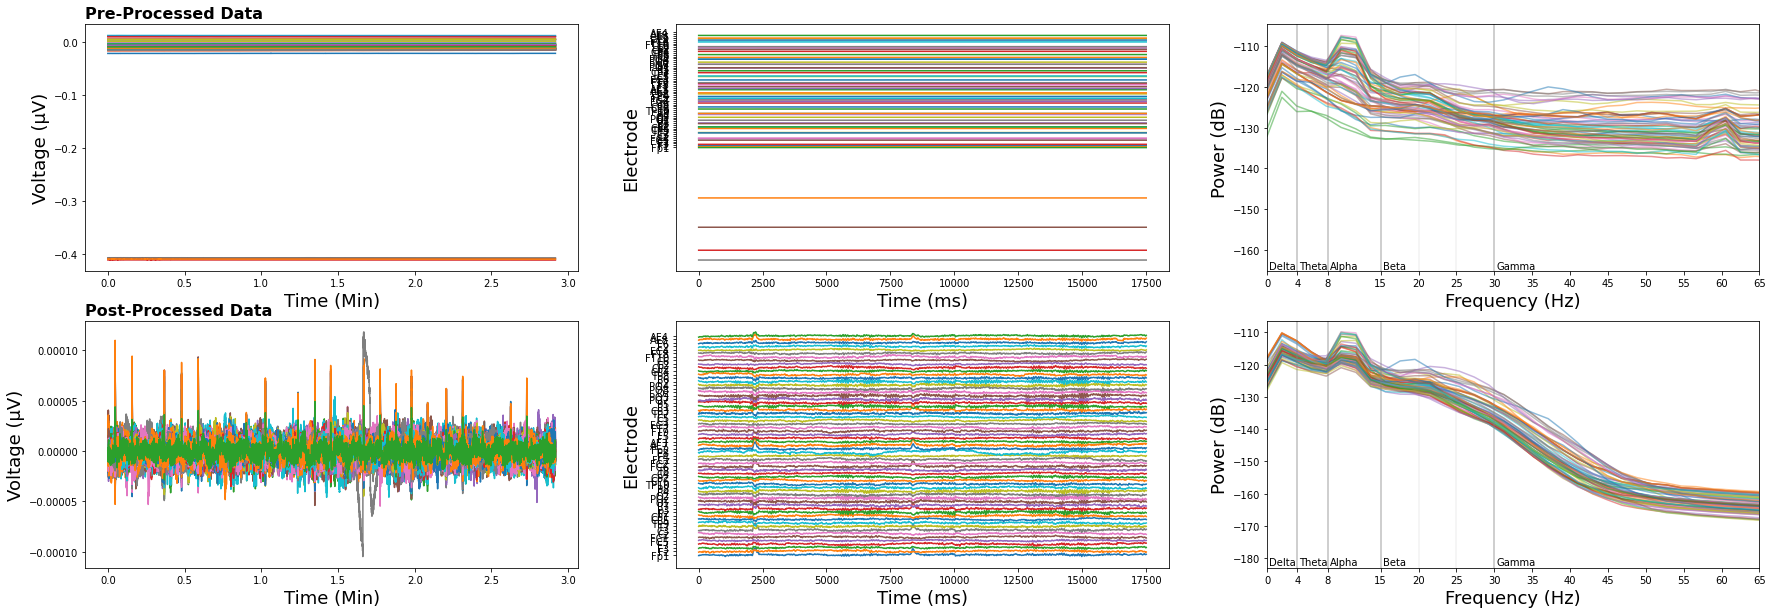

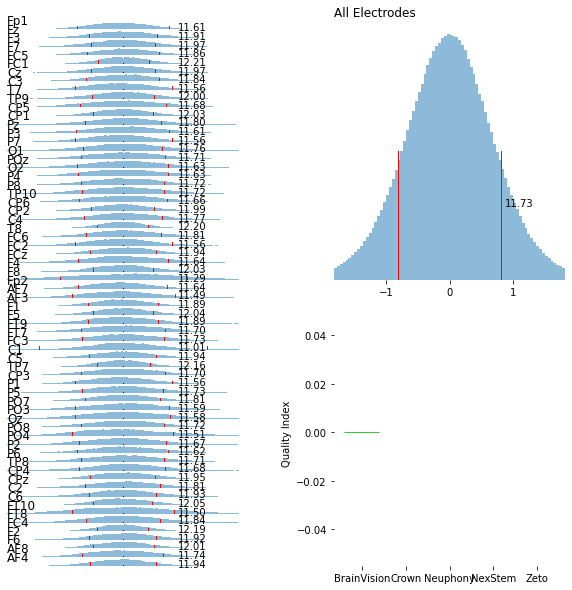

In [3]:
#@title

#### Setup visualization function ####
def plot_EEG(prefilt_data, data, viewer_times): #Create function
  #First, we run PSD transformations. We do this at the top because it has outputs we want to suppress and after these, we clear output to suppress them
  #Here, we display data before and after preprocessing. Whereas before pre-processing data is titled prefilt_data (this variable name is actually incorrect now because the data encompasses more than just pre-filtered data and we may want to change it for readability), post pre-processing data is titled data.
  [pf_PSD_output,pf_PSD_freq] = mne.time_frequency.psd_welch(prefilt_data) #Conduct PSD transforms for the raw data using the welch's method
  [PSD_output,PSD_freq] = mne.time_frequency.psd_welch(data) #Conduct PSD transforms for the processed data using the welch's method

  #Clear output and print info
  clear_output() #This will clear all output from the PSD functions above for a clean display
  print('\033[1m' + 'Selected Device: ' + '\033[0m', Device.value,'\n') #Indicate to user which device they selected
  print('\033[1m' + 'Selected File: ' + '\033[0m', selected_file.value,'\n') #Indicate to user which file they selected

  #Plot Pre-Filt EEG
  matplotlib.rcParams['figure.figsize'] = [30, 10] #Determine size of the figure
  electrodes_to_plot = prefilt_data.get_data().shape[0] #Determine how many electrodes there are in the device selected
  pf_current_data = np.transpose(prefilt_data.get_data()[0:electrodes_to_plot,:]) #Extract data into it's own variable
  plt.subplot(2, 3, 1) #Create first subplot
  plt.plot((EEG.times/60),pf_current_data); #Create butterfly plot
  plt.title('Pre-Processed Data', loc = 'left', fontweight='bold', fontsize=16) #Add title 
  plt.xlabel('Time (Min)', fontsize=18) #Add x label
  plt.ylabel('Voltage ('+'\u03BC'+'V)', fontsize=18) #Add y label
  plt.subplot(2, 3, 2) #Create second subplot
  display_times = range(round(len(EEG.times)*(viewer_times.value[0]/100)), round(len(EEG.times)*(viewer_times.value[1]/100))) #Determine an x-axis with time units
  plt.plot((np.linspace(1,len(display_times),len(display_times))/EEG.info['sfreq'])*1000,np.transpose(prefilt_data.get_data()[0:electrodes_to_plot,display_times])+np.linspace(0,electrodes_to_plot*(prefilt_data.get_data()[0:electrodes_to_plot,display_times].max()*.5),electrodes_to_plot)); #Plot all data with each electrode as its own line
  plt.yticks(np.linspace(0,electrodes_to_plot*(prefilt_data.get_data()[0:electrodes_to_plot,display_times].max()*.5),electrodes_to_plot), prefilt_data.ch_names) #Add electrode labels
  plt.xlabel('Time (ms)', fontsize=18) #Add x label
  plt.ylabel('Electrode', fontsize=18) #Add y label

  #Plot Pre-Filt PSD
  pf_PSD_output = 10 * np.log10(pf_PSD_output) #Convert PSD data to to dB
  plt.subplot(2, 3, 3) #Create third subplot
  plt.plot(pf_PSD_freq,np.transpose(pf_PSD_output),alpha=.5); #Plot PSD data 
  axes = plt.gca() #Extract axes information
  y_min, y_max = axes.get_ylim() #Extract y limits 
  text_offset = (y_max-y_min)*.01 #Determine y-location of text
  plt.xticks((0,4,8,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100)) #Add specific x-tick-labels
  plt.axvline(x=4,alpha=.5,color='grey') #Add grey line to indicate frequency band border 
  plt.text(0.25,y_min+text_offset,'Delta') #Add frequency band label
  plt.axvline(x=8,alpha=.5,color='grey') #Add grey line to indicate frequency band border 
  plt.text(4.25,y_min+text_offset,'Theta') #Add frequency band label
  plt.axvline(x=15,alpha=.5,color='grey') #Add grey line to indicate frequency band border 
  plt.axvline(x=20,alpha=.1,color='grey') #Add grey line to indicate frequency band border 
  plt.axvline(x=25,alpha=.1,color='grey') #Add grey line to indicate frequency band border 
  plt.text(8.25,y_min+text_offset,'Alpha') #Add frequency band label
  plt.axvline(x=30,alpha=.5,color='grey') #Add grey line to indicate frequency band border 
  plt.text(15.25,y_min+text_offset,'Beta') #Add frequency band label
  plt.text(30.25,y_min+text_offset,'Gamma') #Add frequency band label
  plt.xlim([0, 65]) #Set x-axis limits
  plt.xlabel('Frequency (Hz)', fontsize=18) #Add x label
  plt.ylabel('Power (dB)', fontsize=18); #Add y label
  
  #Plot EEG
  electrodes_to_plot2 = data.get_data().shape[0] #Determine how many electrodes there are in the device selected
  current_data = np.transpose(data.get_data()[0:electrodes_to_plot2,:]) #Extract data into it's own variable
  plt.subplot(2, 3, 4) #Create fourth subplot
  plt.plot((EEG.times/60),current_data); #Create butterfly plot
  plt.title('Post-Processed Data', loc = 'left', fontweight='bold', fontsize=16) #Add title 
  plt.xlabel('Time (Min)', fontsize=18) #Add x label
  plt.ylabel('Voltage ('+'\u03BC'+'V)', fontsize=18); #Add y label
  plt.subplot(2, 3, 5) #Create fifth subplot
  plt.plot((np.linspace(1,len(display_times),len(display_times))/EEG.info['sfreq'])*1000,np.transpose(data.get_data()[0:electrodes_to_plot2,display_times])+np.linspace(0,electrodes_to_plot2*(data.get_data()[0:electrodes_to_plot2,display_times].max()*.5),electrodes_to_plot2)); #Plot all data with each electrode as its own line
  plt.yticks(np.linspace(0,electrodes_to_plot2*(data.get_data()[0:electrodes_to_plot2,display_times].max()*.5),electrodes_to_plot2), data.ch_names) #Add electrode labels
  plt.xlabel('Time (ms)', fontsize=18) #Add x label
  plt.ylabel('Electrode', fontsize=18); #Add y label

  #Plot PSD
  PSD_output = 10 * np.log10(PSD_output) #Convert PSD data to to dB
  plt.subplot(2, 3, 6) #Create sixth subplot
  plt.plot(PSD_freq,np.transpose(PSD_output),alpha=.5); #Plot PSD data 
  axes = plt.gca() #Extract axes information
  y_min, y_max = axes.get_ylim() #Extract y limits 
  text_offset = (y_max-y_min)*.01 #Determine y-location of text
  plt.xticks((0,4,8,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100)) #Add specific x-tick-labels
  plt.axvline(x=4,alpha=.5,color='grey') #Add grey line to indicate frequency band border 
  plt.text(0.25,y_min+text_offset,'Delta') #Add frequency band label
  plt.axvline(x=8,alpha=.5,color='grey') #Add grey line to indicate frequency band border
  plt.text(4.25,y_min+text_offset,'Theta') #Add frequency band label
  plt.axvline(x=15,alpha=.5,color='grey') #Add grey line to indicate frequency band border
  plt.axvline(x=20,alpha=.1,color='grey') #Add grey line to indicate frequency band border
  plt.axvline(x=25,alpha=.1,color='grey') #Add grey line to indicate frequency band border
  plt.text(8.25,y_min+text_offset,'Alpha') #Add frequency band label
  plt.axvline(x=30,alpha=.5,color='grey') #Add grey line to indicate frequency band border
  plt.text(15.25,y_min+text_offset,'Beta') #Add frequency band label
  plt.text(30.25,y_min+text_offset,'Gamma') #Add frequency band label
  plt.xlim([0, 65]) #Set x-axis limits
  plt.xlabel('Frequency (Hz)', fontsize=18) #Add x label
  plt.ylabel('Power (dB)', fontsize=18); #Add y label

#### LOAD DATA ####
if Device.value == 'Artificial': #If artificial data was selected
  #Here, we use the sum of sine waves with randomized amplitude and phase to create artificial data
  print('Artificial data selected!\n\nCreating data for electrode:') #Inform user that data is being simulated and indicates progress through electrode being processed

  #Determine data characteristics
  sampling_rate = 250 #Determine sampling rate
  number_electrode = 16 #Determine number of electrodes
  number_frequency = 100 #Determine number 
  time = np.arange(0,120,1/sampling_rate)

  #Create artificial data
  frequency_resolution = sampling_rate/time.shape[0] #Determine frequency resolution
  real_frequency = np.arange(frequency_resolution, number_frequency, frequency_resolution) #Create array of frequencies
  amplitude = np.empty((number_electrode,real_frequency.shape[0],1)) #Create empty variable for amplitudes
  theta = np.empty((number_electrode,real_frequency.shape[0],1)) #Create empty variable for phases
  EEG = np.empty((number_electrode,time.shape[0])) #Create empty variable for data
  for electrode in range(0,number_electrode): #Cycle through electrodes
    print(electrode) #Inform user which electrode is being simulated
    sinewave = np.empty((real_frequency.shape[0],time.shape[0])) #Create empty variable for electrode specific sine waves
    frequency_index = 0 #Index for storing frequency data
    for frequency in real_frequency:#Cycle through frequencies
      amplitude[electrode,frequency_index] = abs(np.random.normal(0,.1)) #Create a random amplitude for this frequency in this electrode
      theta[electrode,frequency_index] = np.random.uniform(-10,10) #Create a random phase for this frequency in this electrode
      sinewave[frequency_index,:] = amplitude[electrode,frequency_index]*np.sin(2*np.pi*frequency*time+theta[electrode,frequency_index]) #Construct the sine wave
      frequency_index += 1 #Increase frequency index
    EEG[electrode,:] = np.sum(sinewave,axis=0)+np.random.normal(0,2,time.shape[0]) #Sum frequency data to simulate EEG activity for this electrode and add noise to data

  #Convert simulated data into mne format
  #Determine electrode information by drawing from a different device
  electrode_labels = np.genfromtxt('nexstem/test.csv', delimiter=',', names=True).dtype.names[0:16]   #Create MNE EEG info
  eeg_info = mne.create_info(ch_names=electrode_labels,ch_types='eeg',sfreq=sampling_rate)
  #Create MNE structure
  EEG = mne.io.RawArray(EEG,eeg_info)
  #Load montage
  electrode_positions = mne.channels.read_custom_montage('Montages/nexstem.txt')
  #Set montage
  EEG.set_montage(electrode_positions)
  #Load EEG data
  EEG.load_data()

elif Device.value == 'NexStem': #If NexStem was selected
  print('NexStem data selected!\n') #Inform user on the device selected

  #Read CSV
  EEG = np.genfromtxt('nexstem/'+selected_file.value, delimiter=',', skip_header=1)
  #Remove non-EEG
  EEG = np.delete(EEG,np.s_[16::],axis=1)
  #Transpose data for MNE format
  EEG = np.transpose(EEG)
  #Determine electrode labels
  electrode_labels = np.genfromtxt('nexstem/test.csv', delimiter=',', names=True).dtype.names[0:16]
  #Create MNE EEG info
  eeg_info = mne.create_info(ch_names=electrode_labels,ch_types='eeg',sfreq=256)
  #Create MNE structure
  EEG = mne.io.RawArray(EEG,eeg_info)
  #Load montage
  electrode_positions = mne.channels.read_custom_montage('Montages/nexstem.txt')
  #Set montage
  EEG.set_montage(electrode_positions)
  #Load EEG data
  EEG.load_data()

elif Device.value == 'Zeto': #If NexStem was selected
  print('Zeto data selected!\n') #Inform user on the device selected
  #Read EDF
  EEG = mne.io.read_raw_edf('Zeto/'+selected_file.value,preload=True)
  #Remove non-EEG channels
  if selected_file.value == 'jenn.edf': #A recording-specific modification (the Zeto data is not consistent across recordings at this point, so we'll need to adapt this once it's stabilized)
    EEG.drop_channels(['ECG']) #Remove ECG data
  #Create dictionairy of current and new electrode names (This is necessary because electrode names begin with 'EEG ' and this needs to be removed)
  electrode_dict = {}
  for electrode in range(0,len(EEG.ch_names)): #Cycle through electrodes
    electrode_dict[EEG.ch_names[electrode]]=(EEG.ch_names[electrode][4:]) #Remove the 'EEG ' at the beginning of each electrode label
  #Rename channels in line with montage
  mne.rename_channels(EEG.info,electrode_dict)
  #Load montage
  electrode_positions = mne.channels.read_custom_montage('Montages/zeto.txt')
  #Set montage
  EEG.set_montage(electrode_positions)

elif Device.value == 'Crown': #If Crown was selected
  print('Crown data selected!\n') #Inform user on the device selected
  
  #Read data (The crown comes in both edf and csv files)
  if selected_file.value[-3:] == 'edf': #If datafile is edf format
    #Read EDF
    EEG = mne.io.read_raw_edf('crown-data/'+selected_file.value,preload=True)
  else: #if datafile is CSV format
    #Read CSV
    EEG = np.genfromtxt('crown-data/'+selected_file.value,delimiter=',',skip_header=1)
    #Transpose data for MNE format
    EEG = np.transpose(EEG)
    #Determine electrode labels
    electrode_labels = np.genfromtxt('crown-data/alexni_open.csv', delimiter=',', names=True).dtype.names[0:8]
    #Create MNE EEG info
    eeg_info = mne.create_info(ch_names=electrode_labels,ch_types='eeg',sfreq=256)
    #Create MNE structure
    EEG = mne.io.RawArray(EEG,eeg_info)
    #Load montage
    electrode_positions = mne.channels.read_custom_montage('Montages/crown.txt')
    #Set montage
    EEG.set_montage(electrode_positions)
    #Load EEG data
    EEG.load_data()

elif Device.value == 'BrainVision': #If Brain Vision was selected
  print('Brain Vision data selected!\n') #Inform user on the device selected

  #Read data
  EEG = mne.io.read_raw_brainvision('BrainVision/'+selected_file.value.split('.')[0]+'.vhdr',preload=True)
  #Crop data because it is very long and takes long to process (this may need to be removed when other BV data is added)
  EEG.crop(tmin=175,tmax=350)
  #Load montage
  EEG.set_montage('standard_1020')

elif Device.value == 'Neuphony': #If Neuphony was selected
  print('Neuphony data selected!\n') #Inform user on the device selected

  #Read data
  #The following code is a placeholder for now as neuphony does not have a structure or loading protocol
  import json
  if selected_file.value == 'neuphony.npy': #A recording specific loading
    with open('Neuphony/neuphony.npy', 'rb') as f:
      EEG = np.load(f)
    #Determine electrode labels
    electrode_labels = mne.channels.read_custom_montage('Montages/neuphony.txt').ch_names #Determine device specific electrode array using a montage
    #Create MNE EEG info
    eeg_info = mne.create_info(ch_names=electrode_labels,ch_types='eeg',sfreq=250)
    #Create MNE structure
    EEG = mne.io.RawArray(EEG,eeg_info)
    #Load montage
    electrode_positions = mne.channels.read_custom_montage('Montages/neuphony.txt')
    #Set montage
    EEG.set_montage(electrode_positions)
    #Load EEG data
    EEG.load_data()
  elif selected_file.value == 'alex_2.npy': #A recording specific loading
    with open('Neuphony/alex_2.npy', 'r') as f:
      data_list = json.load(f)
      eeg_list = [s['data'] 
      for sample_group in data_list
      for s in sample_group]
    EEG = np.array(eeg_list).swapaxes(0,1)
    #Determine electrode labels
    electrode_labels = mne.channels.read_custom_montage('Montages/neuphony.txt').ch_names #Determine device specific electrode array using a montage
    #Create MNE EEG info
    eeg_info = mne.create_info(ch_names=electrode_labels,ch_types='eeg',sfreq=250)
    #Create MNE structure
    EEG = mne.io.RawArray(EEG,eeg_info)
    #Load montage
    electrode_positions = mne.channels.read_custom_montage('Montages/neuphony.txt')
    #Set montage
    EEG.set_montage(electrode_positions)
    #Load EEG data
    EEG.load_data()
  else:
    EEG = mne.io.read_raw_edf('Neuphony/'+selected_file.value,preload=True)
    EEG.crop(tmin=10,tmax=EEG.times[-1]) #Couple of files have a big spike at the start, leaving this here if that turns out to be normal for this device
    #Load montage
    electrode_positions = mne.channels.read_custom_montage('Montages/neuphony.txt')
    #Set montage
    EEG.set_montage(electrode_positions)

else: #If no data was selected (technically, impossible)
  print('No data selected!\n') #Inform user that there was an error

#### COPY DATA ####
#Copy data for a before-after plot as defined above
prefilt_EEG = EEG.copy()

#### EDIT CHANNELS ####
if EC == True: #If user wants to edit channels
  bad_electrodes = [] #Create empty variable to store bad electrodes
  for electrode in range(len(available_electrodes)): #Cycle through all electrodes
    if available_electrodes[electrode].value == True: #Determine if current electrode was toggled to be removed
      bad_electrodes.append(available_electrodes[electrode].description) #Add removed electrode to a list
  EEG.info['bads'] = bad_electrodes #Add list of bad electrodes to MNE structure
  EEG.interpolate_bads() #Interpolate all bad electrodes
    
#### RE-REFERENCE ####
if RR == True: #If user wants to re-reference data
  if select_rereference.value == 'Average': #Determine if user wants an average reference
    EEG.set_eeg_reference('average', projection=True) #Create reference
    EEG.apply_proj() #Apply reference
  else: #Determine if user selected a specific reference
    EEG.set_eeg_reference([select_rereference.value]) #Create reference
    EEG.apply_proj() #Apply reference
    EEG.drop_channels([select_rereference.value]) #Remove reference channel

#### FILTER DATA ####
if (HP == True) & (LP == True): #If user wants to use both a high and low pass
  EEG.filter(l_freq=select_highpass.value,h_freq=select_lowpass.value,method='iir') #Filter data with both high pass and low pass
elif (HP == True) & (LP == False): #If user wants to use a high pass only
  EEG.filter(l_freq=select_highpass.value, h_freq=None,method='iir') #Filter data with only high pass
elif (HP == False) & (LP == True): #If user wants to use a low pass only
  EEG.filter(l_freq=None, h_freq=select_lowpass.value,method='iir') #Filter data with only low pass

if Nt == True: #If user wants to use a notch filter
  EEG.notch_filter(np.arange(int(select_notch.value),EEG.info['sfreq']/2, int(select_notch.value)), filter_length='auto', phase='zero') #Apply notch selected and all harmonics

#### ICA FOR BLINK CORRECTION ####
#Note that this is not complete and not properly connected to the front end - in progress
if run_ICA.value: #If user wants to run ICA
  ICA = mne.preprocessing.ICA(n_components=EEG.get_data().shape[0], random_state=0) #Run ICA
  ICA.fit(EEG) #Apply to EEG data

  #Plot ICA results for investigation
  ICA.plot_components() #Plot components
  ICA.plot_sources(EEG) #Plot topographic maps

  ICA.exclude = [] #Manually input components to remove, e.g., ICA.exclude = [0,2,3] - this will need to be introduced in the front end
  EEG = ICA.apply(EEG,exclude=ICA.exclude) #Exclude ICA components selectrd

#### PLOT RESULTS ####
plot_EEG(prefilt_EEG,EEG, viewer_times) #Use above function to plot all data

#### SIGNAL QUALITY ASSESSMENT ####
#Here, we use a standard deviation transformation and plot the results for each electrode and across all electrodes.
#We also display the results of standardized recordings for each device as a benchmark visualization
matplotlib.rcParams['figure.figsize'] = [10, 10] #Determine figure size
plotting_figure = plt.figure(constrained_layout=False); #Adds more functionality

#Electrode specific histograms
gs = plotting_figure.add_gridspec(EEG.get_data().shape[0], 7) #Add subplot panels
Outlier_criterion = np.percentile(np.abs(np.asarray(EEG.get_data()).flatten()),99) #Create new variable with collapsed data
for electrode in range(0,EEG.get_data().shape[0]): #Cycle through electrodes
  ax = plotting_figure.add_subplot(gs[electrode, 0:3]) #Add subplot
  plt.hist(EEG.get_data()[electrode,:][np.abs(EEG.get_data()[electrode,:])<Outlier_criterion],alpha=0.5,bins=100,density=1) #Add histogram of all values of the current electrode
  plt.axvline(np.mean(EEG.get_data()[electrode,:])-np.std(EEG.get_data()[electrode,:]), ymin=0, ymax=.5, color='r', linewidth=1) #Add red vertical bar at the -1SD
  plt.axvline(np.mean(EEG.get_data()[electrode,:])+np.std(EEG.get_data()[electrode,:]), ymin=0, ymax=.5, color='r', linewidth=1) #Add red vertical bar at the +1SD
  plt.axvline(0, ymin=-.1, ymax=.1, color='black', linewidth=1) #Add red vertical bar at the -1SD
  plt.xlim(-np.percentile(np.abs(np.asarray(EEG.get_data()).flatten()),99),np.percentile(np.abs(np.asarray(EEG.get_data()).flatten()),99)) #Determine x limit to be the 99.9th percentiles (this allows the removal of a small number of very extreme scores)
  plt.axis('off') #Remove axes
  plt.title(EEG.info['ch_names'][electrode],loc='left',y=-.1) #Add electrode name
  plt.text(.8, .3,'{:.2f}'.format(np.round(np.log(1/np.std(EEG.get_data()[electrode,:])),decimals=2)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes); #Add transformed SD value

#All data histogram
ax = plotting_figure.add_subplot(gs[:int(EEG.get_data().shape[0]/2)-1, 4:7]) #Add subplot
All_EEG = np.asarray(EEG.get_data()).flatten() #Flatten EEG matrix
plt.hist(All_EEG[np.abs(All_EEG)<Outlier_criterion],alpha=0.5,bins=100) #Add histogram for all data across all electrodes, but removing data more extreme than 2.5 & 97.5 percentiles
plt.axvline(np.mean(np.asarray(EEG.get_data()).flatten())-np.std(np.asarray(EEG.get_data()).flatten()), ymin=0, ymax=.5, color='r', linewidth=1) #Add red vertical bar at the -1SD
plt.axvline(np.mean(np.asarray(EEG.get_data()).flatten())+np.std(np.asarray(EEG.get_data()).flatten()), ymin=0, ymax=.5, color='r', linewidth=1) #Add red vertical bar at the +1SD
plt.xlim(-np.percentile(np.abs(np.asarray(EEG.get_data()).flatten()),97.5),np.percentile(np.abs(np.asarray(EEG.get_data()).flatten()),97.5)) #Determine x limit to be the 99.9th percentiles (this allows the removal of a small number of very extreme scores)
plt.title('All Electrodes',loc='left',y=1); #Add title
ax.spines['left'].set_visible(False) #Remove axis
ax.spines['top'].set_visible(False) #Remove axis
ax.spines['right'].set_visible(False) #Remove axis
ax.spines['bottom'].set_visible(False) #Remove axis
ax.axes.yaxis.set_visible(False) #Remove axis
plt.yticks(color='w'); #Hide y-ticks
plt.text(.8, .3,'{:.2f}'.format(np.round(np.log(1/np.std(EEG.get_data().flatten())),decimals=2)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes); #Add transformed SD value

#Benchmark bar plot
ax = plotting_figure.add_subplot(gs[int((EEG.get_data().shape[0]/2)+1):, 4:7]) #Add subplot
#Currently have not received standardized recordings and thus benchmark assessments are not complete. Once data is received, this will need to be converted to a text file rather than hard coded here for the ability to manipulate these values with new recordings
SDs = {'BrainVision' : 1, 'Crown' : 1, 'Neuphony' : 1, 'NexStem' : 1, 'Zeto' : 1}

#Convert benchmark values
sorted_order = sorted(SDs,key=SDs.get) #Determine and order of quality
sorted_SDs = {} #Create an empty variable to hold transformed data
for index in sorted_order: #Cycle through devices
    sorted_SDs[index] = 1/SDs[index] #Transform SDs

#Plot benchmark
bar_list = plt.bar(sorted_SDs.keys(),np.log(list(sorted_SDs.values()))); #Create bar plot and further transform the SDs
ax.spines['left'].set_visible(False) #Remove axis
ax.spines['top'].set_visible(False) #Remove axis
ax.spines['right'].set_visible(False) #Remove axis
ax.spines['bottom'].set_visible(False) #Remove axis
plt.ylabel('Quality Index'); #Add title
if Device.value != 'Artificial': #Artificial data is not part of the benchmark, so only do the following if user is using one of the approved devices
  bar_list[list(sorted_SDs.keys()).index(Device.value)].set_color('limegreen') #Indicate which device user is using by changing the colour

